<h2 style="text-align: center;">Generalized method of moments</h2>


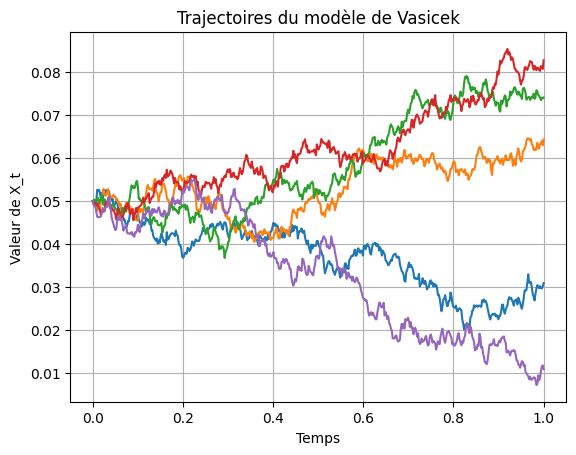

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class Vasicek:
    def __init__(self, kappa, theta, sigma):
        """
        Initialise les paramètres du modèle de Vasicek.
        
        :param kappa: vitesse de réversion vers la moyenne
        :param theta: niveau de la moyenne à long terme
        :param sigma: volatilité du processus
        """
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma

    def generate(self, X0, N, n):
        """
        Génère N trajectoires du processus Vasicek sur [0, 1] avec un pas de 1/n.
        
        :param X0: valeur initiale du processus
        :param N: nombre de trajectoires à générer
        :param n: nombre de pas de discrétisation (soit 1/n pour le pas de temps)
        
        :return: tableau de N trajectoires discrétisées du processus Vasicek
        """
        # Pas de temps
        dt = 1 / n
        # Nombre de pas de discrétisation
        steps = n
        # Initialisation du tableau pour les trajectoires
        trajectories = np.zeros((N, steps))
        
        for i in range(N):
            # Trajectoire initiale
            X = np.zeros(steps)
            X[0] = X0
            for t in range(1, steps):
                # Calcul de la prochaine valeur de la trajectoire
                dW = np.random.normal(0, np.sqrt(dt))  # incrément de Wiener
                dX = self.kappa * (self.theta - X[t-1]) * dt + self.sigma * dW
                X[t] = X[t-1] + dX  # mise à jour de X
            trajectories[i] = X
        
        return trajectories

# Paramètres du modèle de Vasicek
kappa = 0.1  # vitesse de réversion vers la moyenne
theta = 0.05  # niveau de la moyenne à long terme
sigma = 0.02  # volatilité du processus
X0 = 0.05  # valeur initiale
N = 5  # nombre de trajectoires à générer
n = 500  # nombre de pas de discrétisation

# Créer un objet de la classe Vasicek
vasicek_process = Vasicek(kappa, theta, sigma)

# Générer les trajectoires
trajectories = vasicek_process.generate(X0, N, n)

# Affichage des trajectoires générées
time = np.linspace(0, 1, n)
for i in range(N):
    plt.plot(time, trajectories[i])
plt.title("Trajectoires du modèle de Vasicek")
plt.xlabel("Temps")
plt.ylabel("Valeur de X_t")
plt.grid(True)
plt.show()
